In [32]:
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt

Helper functions for standirization, tokenization and drawing

In [4]:
def plot_unique_value_counts(df: pd.DataFrame, column: str):
    """
    Plots the count of unique values in a specified DataFrame column using Matplotlib.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The column name to analyze.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    value_counts = df[column].value_counts()

    plt.figure(figsize=(14, 5))
    plt.bar(value_counts.index, value_counts.values, color="royalblue")

    plt.xlabel(column)
    plt.ylabel("Count")
    plt.title(f"Count of Unique Values in '{column}'")
    plt.xticks(rotation=45, ha="right")
    
    plt.show()

In [58]:
def clean_text(sentence):
    # Remove punctuation
    sentence = re.sub(r'[^\w\s]', '', sentence)

    # Remove numbers
    sentence = re.sub(r'\d+', '', sentence)  # Remove números
    
    tokens = sentence.split()

    # remove any words with less than 2 characters
    #filtered_tokens = [token for token in tokens if len(tokens) >= 2]
    
    # Remover stopwords
    lowercased_tokens = [x.lower() for x in tokens]

    # Remove stop words
    filtered_tokens = [token for token in lowercased_tokens if (token not in stop_words)]

    # Combine words again
    cleaned_sentence = ' '.join(filtered_tokens)
    return cleaned_sentence

In [59]:
with open("stopwords-en.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# Remove newline characters
stop_words = [line.strip() for line in lines]

### Step 0: Dataset exploration

In [60]:
raw_dataset = pd.read_csv('expense_classification.csv', sep='|')
raw_dataset[50:60]

#raw_dataset = raw_dataset.sample(frac=1).reset_index(drop=True)
raw_dataset.head()

,Unnamed: 0,micro_category,macro_category,human_strings
0,0,Rent/Mortgage,Housing & Utilities,rent august
1,1,Rent/Mortgage,Housing & Utilities,rent for august
2,2,Rent/Mortgage,Housing & Utilities,august rent payment
3,3,Rent/Mortgage,Housing & Utilities,rent
4,4,Rent/Mortgage,Housing & Utilities,rent payment


In [61]:
raw_dataset

,Unnamed: 0,micro_category,macro_category,human_strings
0,0,Rent/Mortgage,Housing & Utilities,rent august
1,1,Rent/Mortgage,Housing & Utilities,rent for august
2,2,Rent/Mortgage,Housing & Utilities,august rent payment
3,3,Rent/Mortgage,Housing & Utilities,rent
4,4,Rent/Mortgage,Housing & Utilities,rent payment
...,...,...,...,...
3429,3429,Vehicle Maintenance & Repairs,Transportation,automatic emergency braking installation
3430,3430,Vehicle Maintenance & Repairs,Transportation,installed a collision avoidance system
3431,3431,Vehicle Maintenance & Repairs,Transportation,collision avoidance system installation
3432,3432,Vehicle Maintenance & Repairs,Transportation,installed a driver assistance system


In [62]:
raw_dataset['human_strings']

0                                    rent august
1                                rent for august
2                            august rent payment
3                                           rent
4                                   rent payment
                          ...                   
3429    automatic emergency braking installation
3430      installed a collision avoidance system
3431     collision avoidance system installation
3432        installed a driver assistance system
3433       driver assistance system installation
Name: human_strings, Length: 3434, dtype: object

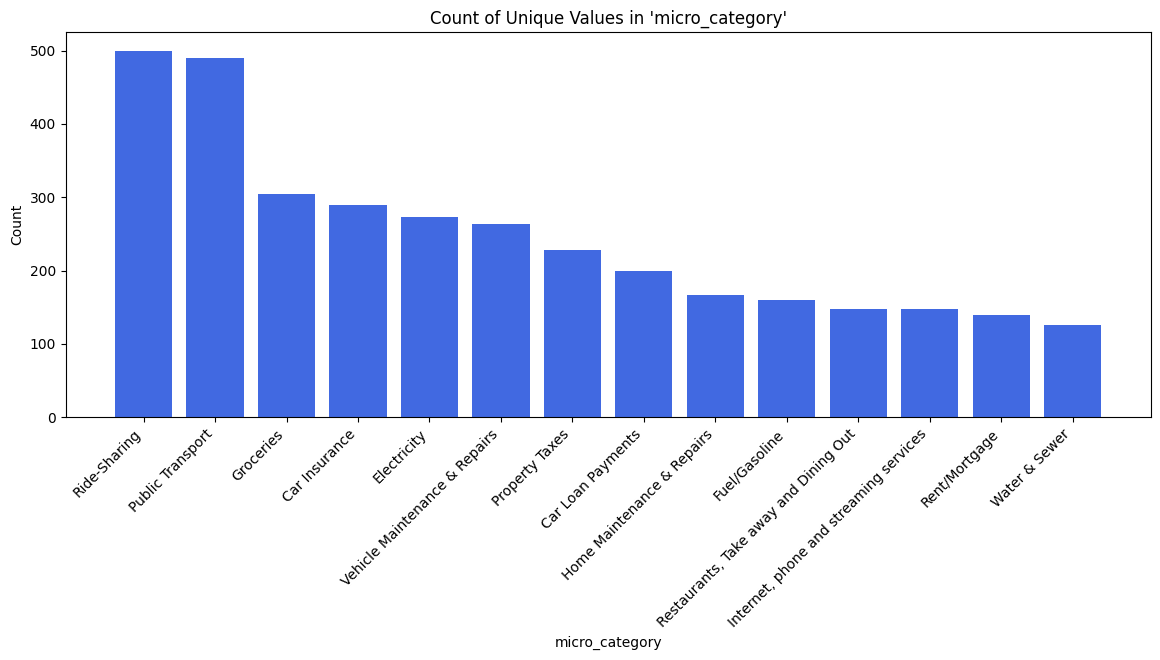

In [63]:
plot_unique_value_counts(raw_dataset, 'micro_category')

In [64]:
count_cat = raw_dataset['micro_category'].value_counts()
count_cat

micro_category
Ride-Sharing                              500
Public Transport                          490
Groceries                                 304
Car Insurance                             290
Electricity                               273
Vehicle Maintenance & Repairs             263
Property Taxes                            228
Car Loan Payments                         200
Home Maintenance & Repairs                166
Fuel/Gasoline                             160
Restaurants, Take away and Dining Out     148
Internet, phone and streaming services    147
Rent/Mortgage                             139
Water & Sewer                             126
Name: count, dtype: int64

### Clean text entries

In [65]:
raw_dataset[5:15]

,Unnamed: 0,micro_category,macro_category,human_strings
5,5,Rent/Mortgage,Housing & Utilities,monthly rent
6,6,Rent/Mortgage,Housing & Utilities,rent august 2024
7,7,Rent/Mortgage,Housing & Utilities,rent mth
8,8,Rent/Mortgage,Housing & Utilities,apartment rent
9,9,Rent/Mortgage,Housing & Utilities,house rent
10,10,Rent/Mortgage,Housing & Utilities,rent this month
11,11,Rent/Mortgage,Housing & Utilities,rent is due
12,12,Rent/Mortgage,Housing & Utilities,gotta pay rent
13,13,Rent/Mortgage,Housing & Utilities,rent's due
14,14,Rent/Mortgage,Housing & Utilities,time to pay rent


In [66]:
raw_dataset['human_strings'] = raw_dataset['human_strings'].apply(clean_text)

In [67]:
raw_dataset[5:15]

,Unnamed: 0,micro_category,macro_category,human_strings
5,5,Rent/Mortgage,Housing & Utilities,monthly rent
6,6,Rent/Mortgage,Housing & Utilities,rent august
7,7,Rent/Mortgage,Housing & Utilities,rent mth
8,8,Rent/Mortgage,Housing & Utilities,apartment rent
9,9,Rent/Mortgage,Housing & Utilities,house rent
10,10,Rent/Mortgage,Housing & Utilities,rent month
11,11,Rent/Mortgage,Housing & Utilities,rent
12,12,Rent/Mortgage,Housing & Utilities,gotta pay rent
13,13,Rent/Mortgage,Housing & Utilities,rents
14,14,Rent/Mortgage,Housing & Utilities,time pay rent


### Step 1: divide the entries into train and test

In [68]:
lines_train = []
lines_validation = []
lines_test = []
categories = raw_dataset['micro_category'].unique()
print(categories)

for category in categories:
    category_filter = raw_dataset['micro_category'] == category
    categories_filtered = raw_dataset[category_filter]
    n_samples = len(categories_filtered)
    # Separate last 20% of df for test
    offset_validation = int(n_samples*0.7)
    offset_test = int(n_samples*0.9)
    for i, row in categories_filtered[0:offset_validation].iterrows():
        lines_train.append([row['human_strings'], category])
    for i, row in categories_filtered[offset_validation:offset_test].iterrows():
        lines_validation.append([row['human_strings'], category])
    for i, row in categories_filtered[offset_test:n_samples].iterrows():
        lines_test.append([row['human_strings'], category])

['Rent/Mortgage' 'Property Taxes' 'Home Maintenance & Repairs'
 'Electricity' 'Water & Sewer' 'Internet, phone and streaming services'
 'Groceries' 'Restaurants, Take away and Dining Out' 'Fuel/Gasoline'
 'Public Transport' 'Ride-Sharing' 'Car Loan Payments' 'Car Insurance'
 'Vehicle Maintenance & Repairs']


In [69]:
lines_train[0:5]

[['rent august', 'Rent/Mortgage'],
 ['rent august', 'Rent/Mortgage'],
 ['august rent payment', 'Rent/Mortgage'],
 ['rent', 'Rent/Mortgage'],
 ['rent payment', 'Rent/Mortgage']]

In [70]:
lines_validation[0:5]

[['rent july', 'Rent/Mortgage'],
 ['mortgage payment', 'Rent/Mortgage'],
 ['mortgage', 'Rent/Mortgage'],
 ['monthly mortgage', 'Rent/Mortgage'],
 ['house mortgage', 'Rent/Mortgage']]

In [71]:
lines_test[0:5]

[['mortgage payment main', 'Rent/Mortgage'],
 ['rent payment oak ave', 'Rent/Mortgage'],
 ['rental payment pine ln', 'Rent/Mortgage'],
 ['monthly payment apartment willow dr', 'Rent/Mortgage'],
 ['housing expense maple', 'Rent/Mortgage']]

In [72]:
print(len(raw_dataset))
print(len(lines_train) + len(lines_test) + len(lines_validation))

3434
3434


In [73]:
dataset_train = pd.DataFrame(data=lines_train, columns = ['human_strings', 'micro_category'])
dataset_train.sample(5)

,human_strings,micro_category
237,property tax valuation,Property Taxes
41,nov rent,Rent/Mortgage
786,morrisons shopping,Groceries
100,real estate tax payment,Property Taxes
222,property tax paid,Property Taxes


In [74]:
dataset_val = pd.DataFrame(data=lines_validation, columns = ['human_strings', 'micro_category'])
dataset_val.sample(5)

,human_strings,micro_category
657,cargo carrier installation,Vehicle Maintenance & Repairs
484,expensive uber,Ride-Sharing
562,paid car loan,Car Loan Payments
587,affordable car insurance quotes,Car Insurance
243,coupons,Groceries


In [75]:
dataset_test = pd.DataFrame(data=lines_test, columns = ['human_strings', 'micro_category'])
dataset_test.sample(5)

,human_strings,micro_category
308,car insurance renewal tomorrow,Car Insurance
346,driver assistance installation,Vehicle Maintenance & Repairs
180,cable car ticket,Public Transport
188,add credit transport card,Public Transport
14,property tax records,Property Taxes


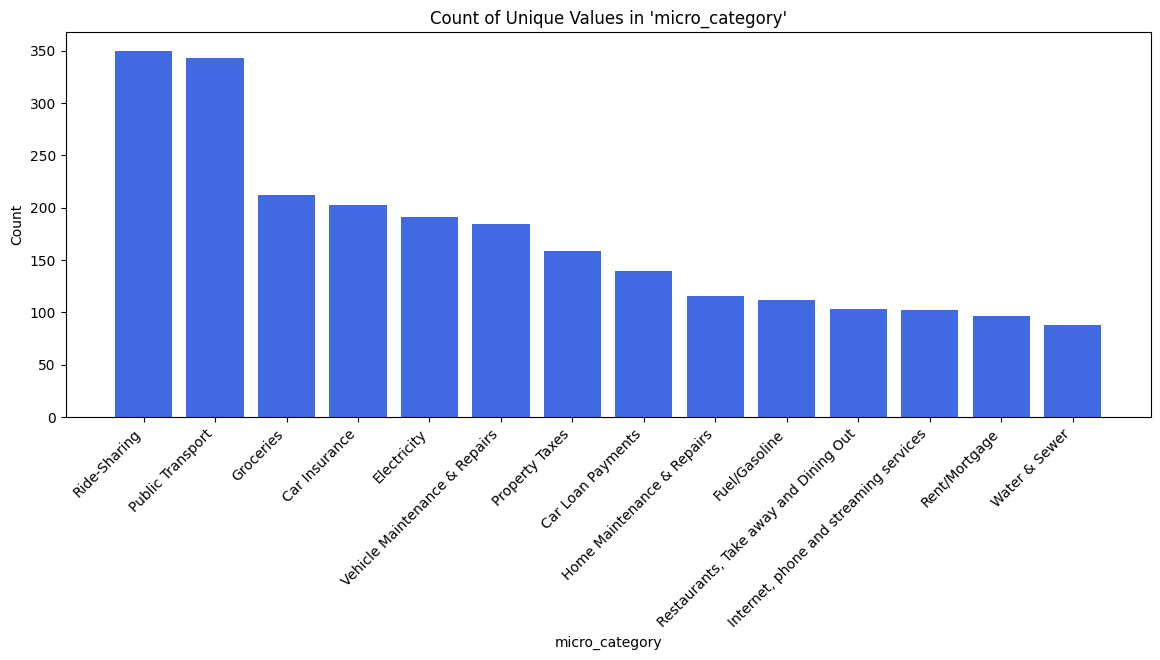

In [76]:
plot_unique_value_counts(dataset_train, 'micro_category')

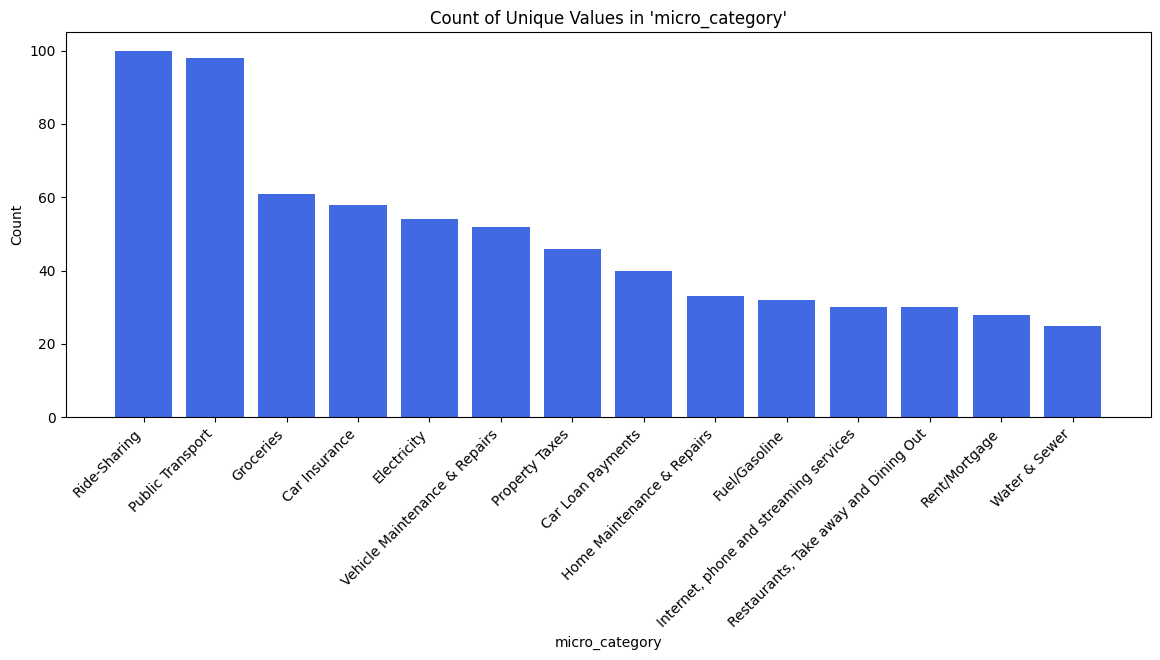

In [77]:
plot_unique_value_counts(dataset_val, 'micro_category')

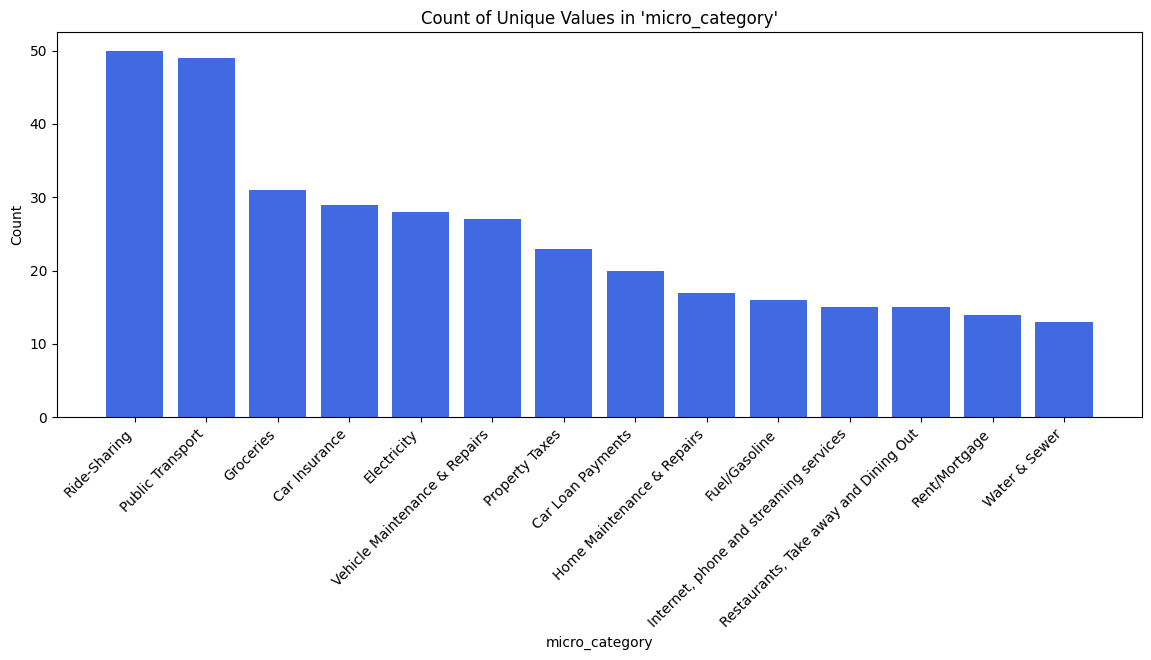

In [78]:
plot_unique_value_counts(dataset_test, 'micro_category')

Most frequent words per category

Rent/Mortgage


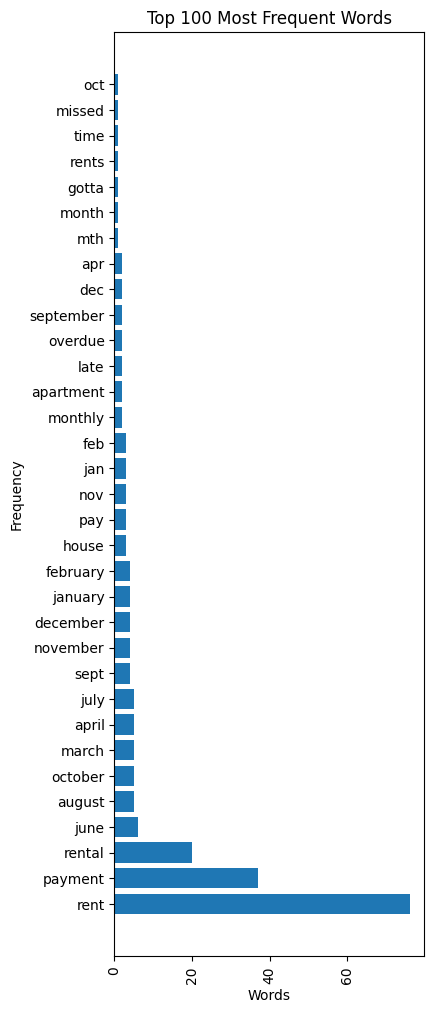

Property Taxes


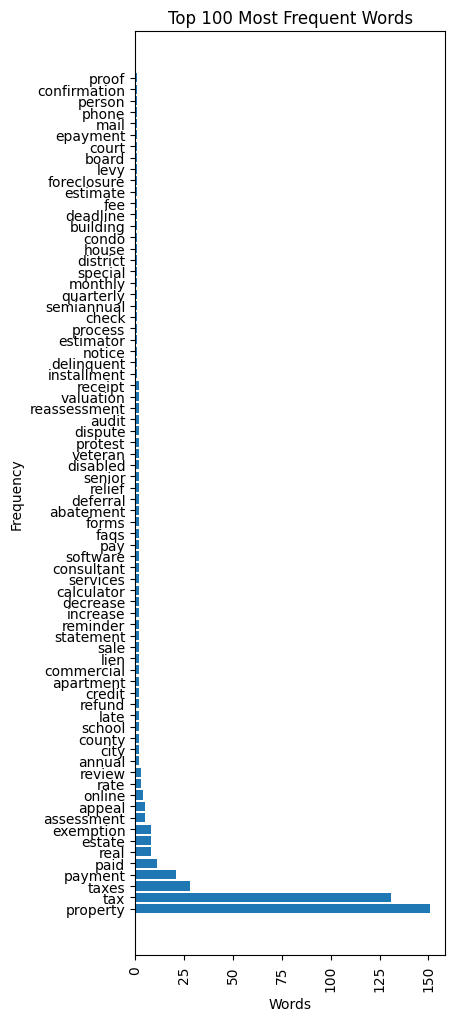

Home Maintenance & Repairs


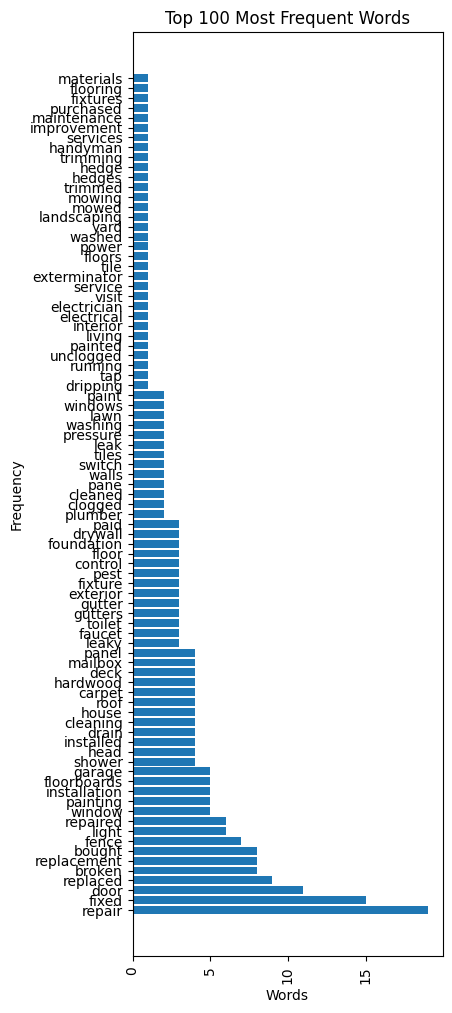

Electricity


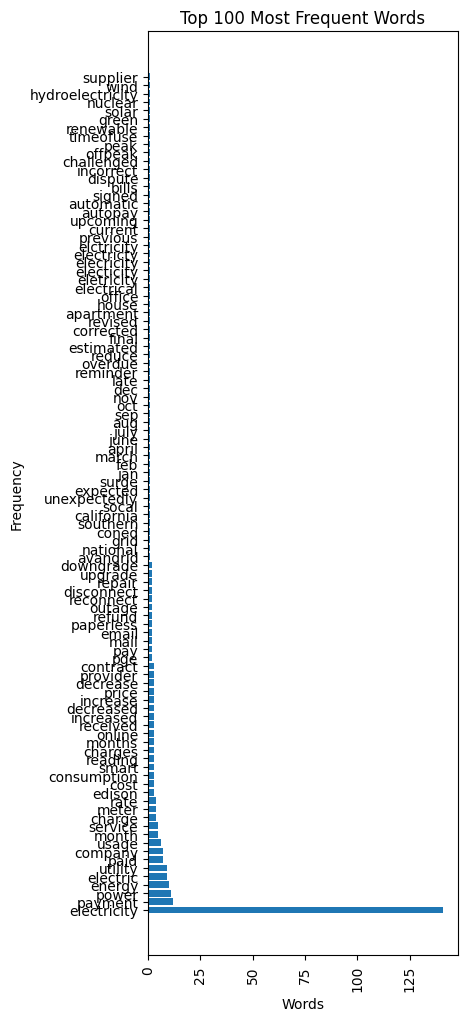

Water & Sewer


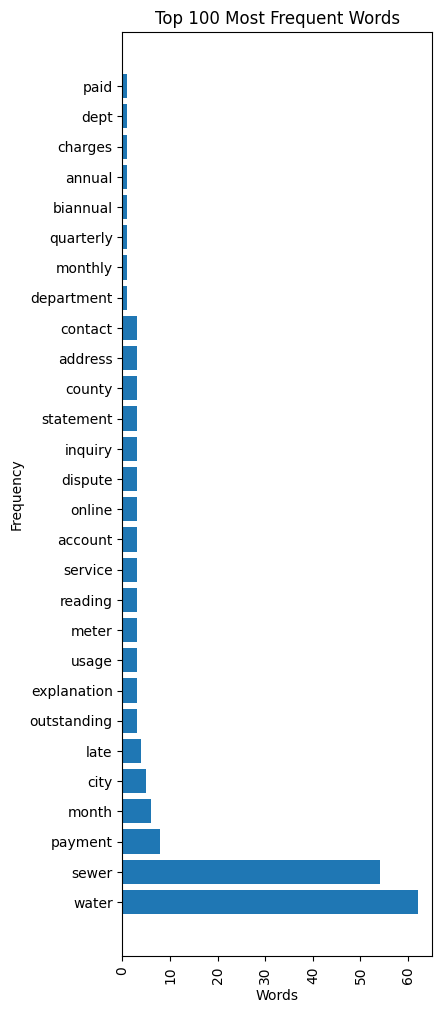

Internet, phone and streaming services


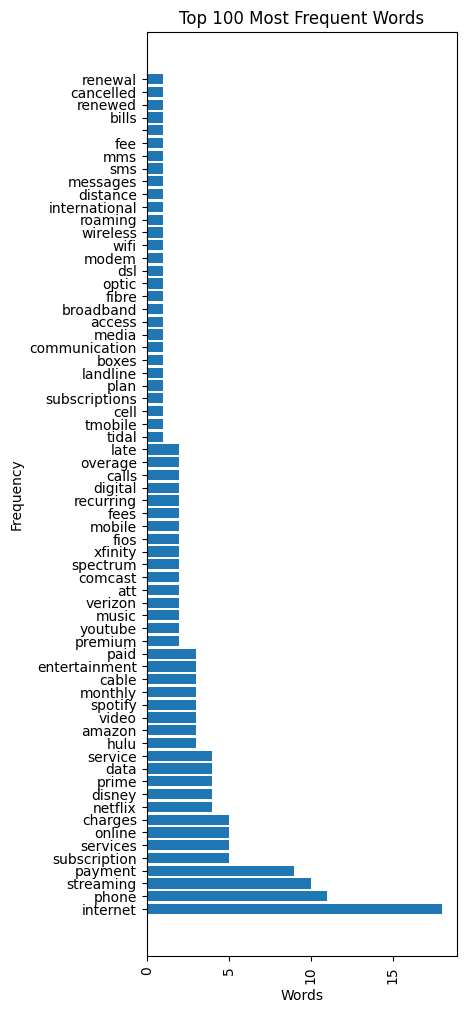

Groceries


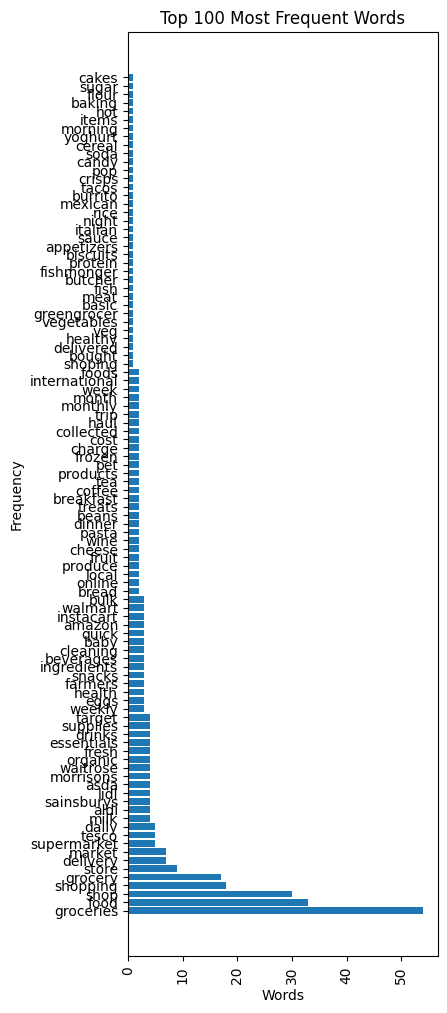

Restaurants, Take away and Dining Out


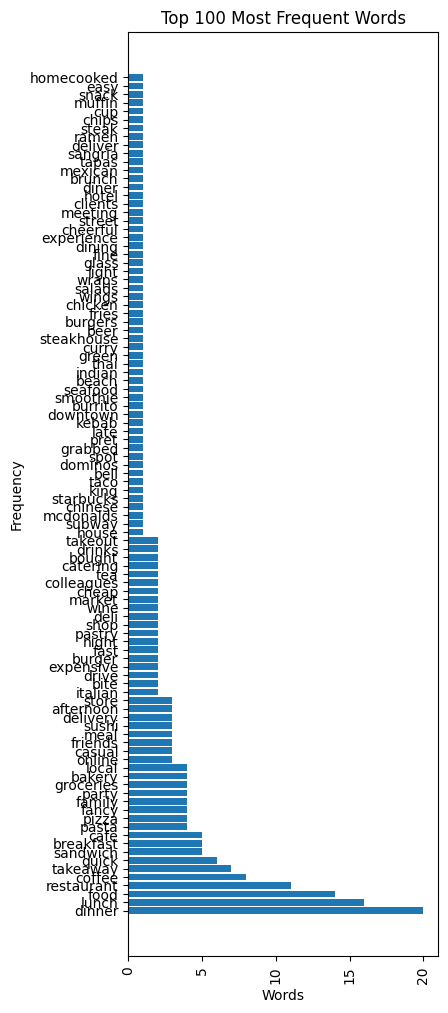

Fuel/Gasoline


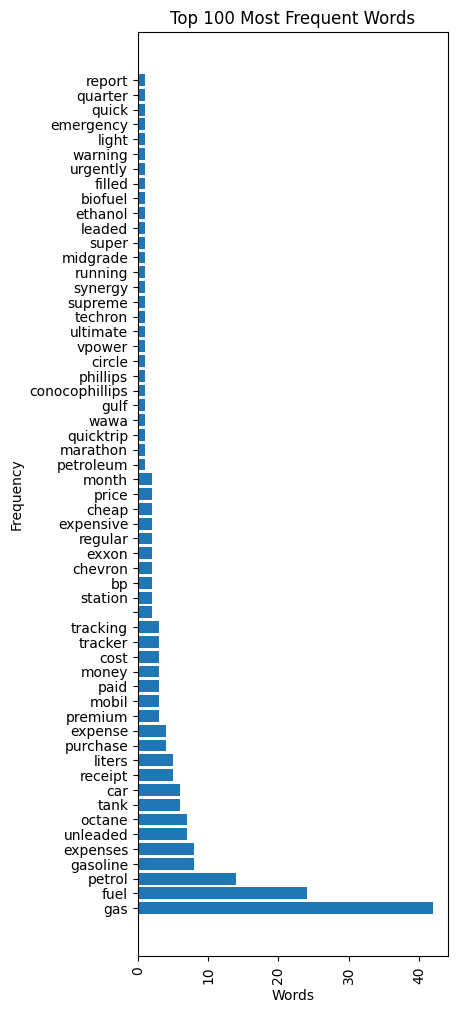

Public Transport


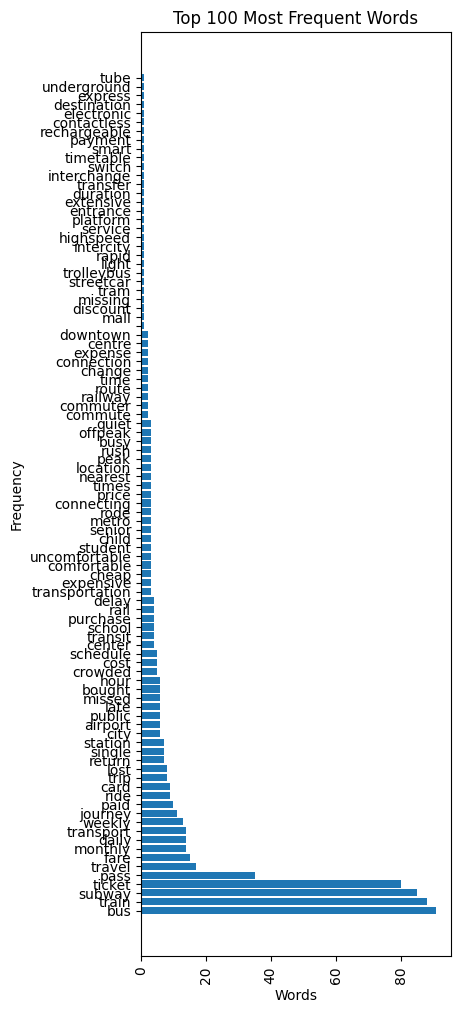

Ride-Sharing


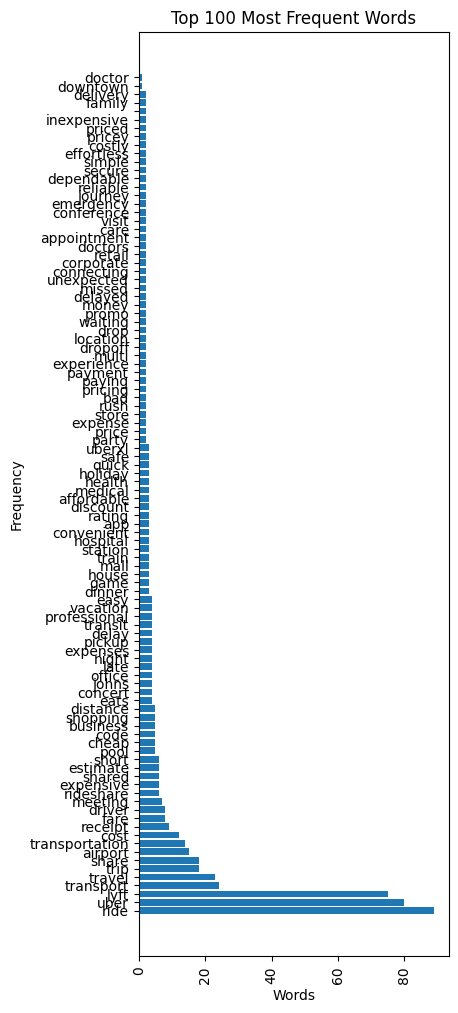

Car Loan Payments


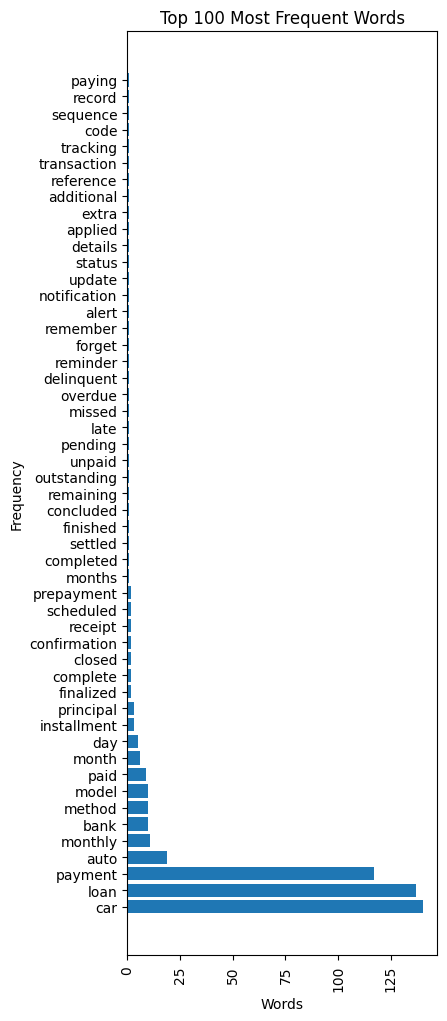

Car Insurance


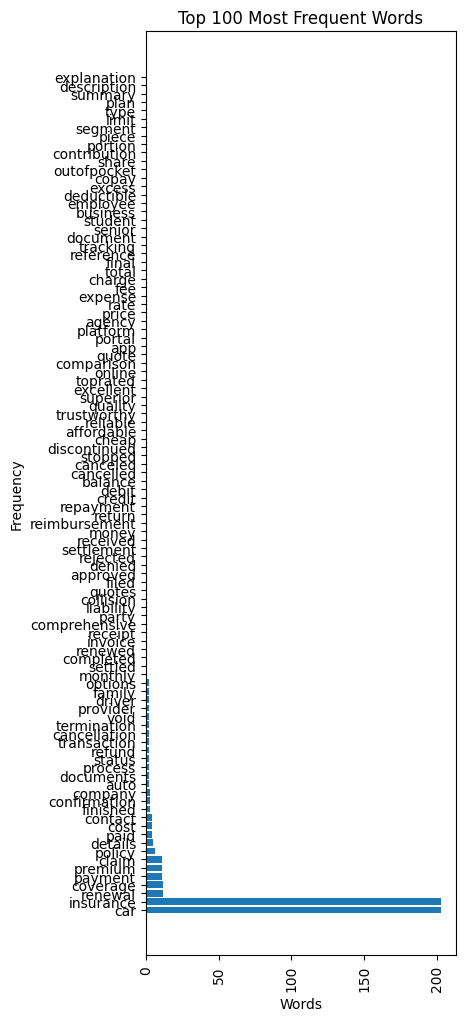

Vehicle Maintenance & Repairs


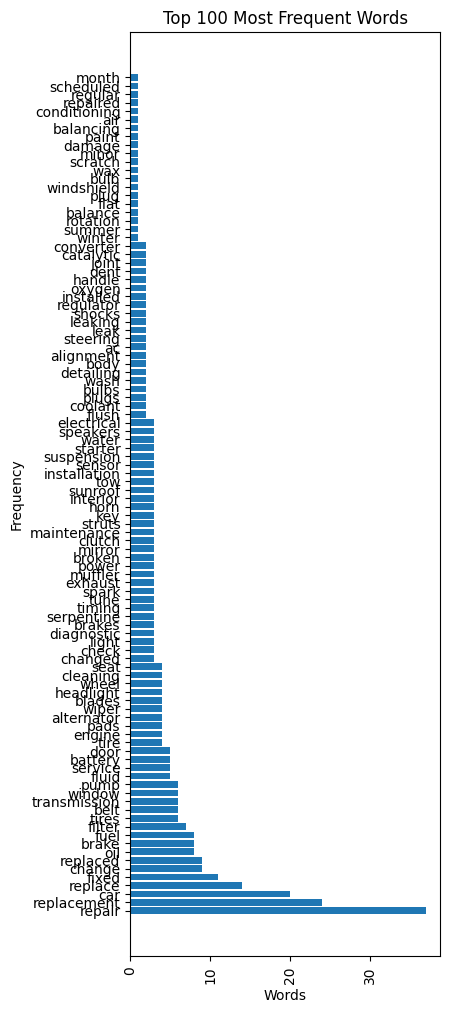

In [79]:

for cat in dataset_train['micro_category'].unique():
    print(cat)
    all_words = []
    cat_filter = dataset_train['micro_category']==cat
    for i, sentence in dataset_train[cat_filter].iterrows():
        words = sentence['human_strings'].split(' ')
        all_words.extend(words)
    
    # Count word frequencies
    word_counts = Counter(all_words)
    
    # Get top 100 words
    top_words = word_counts.most_common(100)
    
    # Convert to lists for plotting
    words, counts = zip(*top_words)
    
    # Plot
    plt.figure(figsize=(4, 12))
    plt.barh(words, counts)
    plt.xticks(rotation=90)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title("Top 100 Most Frequent Words")
    plt.show()

### Mapping and encoding

In [80]:
# We will track the result of all approaches
strategies = []

Encoding Labels (Y)

In [81]:
label_dict = {cat: i for i, cat in enumerate(dataset_train['micro_category'].unique())}
label_dict

{'Rent/Mortgage': 0,
 'Property Taxes': 1,
 'Home Maintenance & Repairs': 2,
 'Electricity': 3,
 'Water & Sewer': 4,
 'Internet, phone and streaming services': 5,
 'Groceries': 6,
 'Restaurants, Take away and Dining Out': 7,
 'Fuel/Gasoline': 8,
 'Public Transport': 9,
 'Ride-Sharing': 10,
 'Car Loan Payments': 11,
 'Car Insurance': 12,
 'Vehicle Maintenance & Repairs': 13}

In [82]:
inverse_label_dict = dict(enumerate(dataset_train['micro_category'].unique()))
inverse_label_dict

{0: 'Rent/Mortgage',
 1: 'Property Taxes',
 2: 'Home Maintenance & Repairs',
 3: 'Electricity',
 4: 'Water & Sewer',
 5: 'Internet, phone and streaming services',
 6: 'Groceries',
 7: 'Restaurants, Take away and Dining Out',
 8: 'Fuel/Gasoline',
 9: 'Public Transport',
 10: 'Ride-Sharing',
 11: 'Car Loan Payments',
 12: 'Car Insurance',
 13: 'Vehicle Maintenance & Repairs'}

In [83]:
def to_one_hot(labels, label_dict, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label_dict[label]] = 1.
    return results

In [84]:
num_classes = len(dataset_train['micro_category'].unique())
print('Number of classes:', num_classes)

Number of classes: 14


In [85]:
# Original labels
y_train_labels = dataset_train['micro_category']
y_val_labels = dataset_val['micro_category']
y_test_labels = dataset_test['micro_category']

# One hot encoded labels
y_train = to_one_hot(y_train_labels, label_dict, num_classes)
y_val = to_one_hot(y_val_labels, label_dict, num_classes)
y_test = to_one_hot(y_test_labels, label_dict, num_classes)

In [86]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Model 1 - Sequential Dense models - Unigrams

981
tf.Tensor(
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0

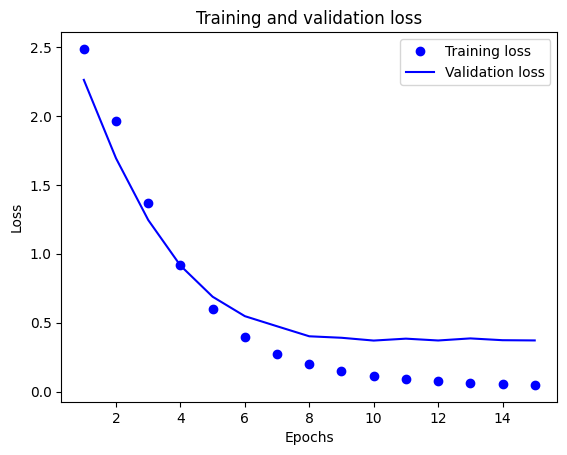

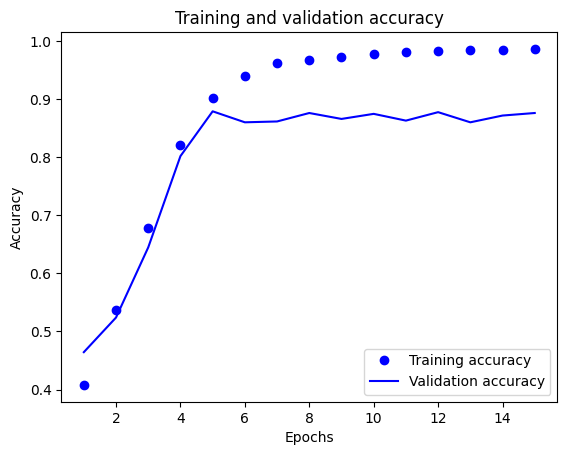

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8684 - loss: 0.4578
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
mortgage payment main |PRED| Internet, phone and streaming services |TRUE| Rent/Mortgage
monthly payment apartment willow dr |PRED| Internet, phone and streaming services |TRUE| Rent/Mortgage
housing expense maple |PRED| Public Transport |TRUE| Rent/Mortgage
mortgage |PRED| Groceries |TRUE| Rent/Mortgage
mortgage |PRED| Groceries |TRUE| Rent/Mortgage
mortgage check |PRED| Vehicle Maintenance & Repairs |TRUE| Rent/Mortgage
check mortgage |PRED| Vehicle Maintenance & Repairs |TRUE| Rent/Mortgage
replaced wornout weather stripping |PRED| Vehicle Maintenance & Repairs |TRUE| Home Maintenance & Repairs
installed towel bar |PRED| Vehicle Maintenance & Repairs |TRUE| Home Maintenance & Repairs
replaced broken door handle |PRED| Vehicle Maintenance & Repairs |TRUE| Home Maintenance & Repairs
carpentry shelf |PRED| Groceries |TRUE| Home Maintenance & Repairs
stand mixer |PRED| Groceries 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │       125,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,030 (1.10 MB)

 Trainable params: 144,014 (562.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 144,016 (562.57 KB)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 981)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14)             │       144,014 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,014 (562.55 KB)

 Trainable params: 144,014 (562.55 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# How to transform the textual input into vector representation
text_vectorization = TextVectorization(
    output_mode="multi_hot",
    max_tokens=15000,
    #output_sequence_length=10,
    ngrams=1,
    #output_mode ='tf_idf',
    #standardize=custom_standardization_fn,
    #split=custom_split_fn,
)

train_texts = dataset_train['human_strings'].to_list()
text_vectorization.adapt(train_texts)

vocabulary = text_vectorization.get_vocabulary()
inverse_vocab = dict(enumerate(vocabulary))

print(text_vectorization.vocabulary_size())

batch_size = 128

val_texts = dataset_val['human_strings'].to_list()
#val_texts = text_vectorization(val_texts) # Encoded validation dataset

test_texts = dataset_test['human_strings'].to_list()
#test_texts = text_vectorization(test_texts)

train_ds = tf.data.Dataset.from_tensor_slices((train_texts, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((val_texts, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((test_texts, y_test))

train_ds = train_ds.shuffle(4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[4])
    print("targets[0]:", targets[4])
    break

model = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    #layers.Dense(32, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint("expenses_unigram_dense_model.keras",
                                    save_best_only=True)
]

history = model.fit(binary_1gram_train_ds,
                    epochs=15,
                    #batch_size=512,
                    validation_data=binary_1gram_val_ds,
                    callbacks=callbacks
                   )

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

results = model.evaluate(binary_1gram_test_ds)

strategies.append({'experiment': 'Unigrams - Pure sequential dense model',
                   'loss': results[0],
                   'test_accuracy': results[1]})

predictions = model.predict(binary_1gram_test_ds)

mistakes = 0
for i, pred in enumerate(predictions):
    text = test_texts[i]
    label = y_test_labels[i]
    predicted_label = inverse_label_dict[np.argmax(pred)]
    if predicted_label != label:
        mistakes += 1
        print(text, '|PRED|', predicted_label, '|TRUE|', label)
print('Mistakes', mistakes)

raw_text_data = tf.convert_to_tensor(test_texts)


trained_model = keras.models.load_model("expenses_unigram_dense_model.keras")
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = trained_model(processed_inputs)
inference_model = keras.Model(inputs, outputs)


predictions = inference_model(raw_text_data)
mistakes = 0
for i, pred in enumerate(predictions[0:5]):
    text = test_texts[i]
    label = y_test_labels[i]
    predicted_label = inverse_label_dict[np.argmax(pred)]
    if predicted_label != label:
        mistakes += 1
        print(text, '|PRED|', predicted_label, '|TRUE|', label)
print('Mistakes:', mistakes)

model.summary()
inference_model.summary()

inference_model.save('expenses_unigram_inference_model.keras')

#### Model 2 - Sequential Dense models - Multi-hot-encoding - Bigrams

2825
tf.Tensor([1 0 0 ... 0 0 0], shape=(2825,), dtype=int64)
inputs.shape: (128, 2825)
inputs.dtype: <dtype: 'int64'>
targets.shape: (128, 14)
targets.dtype: <dtype: 'float64'>
inputs[0]: tf.Tensor([0 0 0 ... 0 0 0], shape=(2825,), dtype=int64)
targets[0]: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(14,), dtype=float64)
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3349 - loss: 2.5397 - val_accuracy: 0.4920 - val_loss: 2.1568
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5397 - loss: 1.9543 - val_accuracy: 0.5852 - val_loss: 1.5597
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6848 - loss: 1.3698 - val_accuracy: 0.7540 - val_loss: 1.1153
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8436 - loss: 0.8371 - val_accuracy: 0.8137 - val_loss: 0.8045
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9178 - loss: 0.5217 - val_accuracy: 0.8923 - val_loss: 0.6082
Epoch 6/10
19/19 ━━━━━━━━━━━

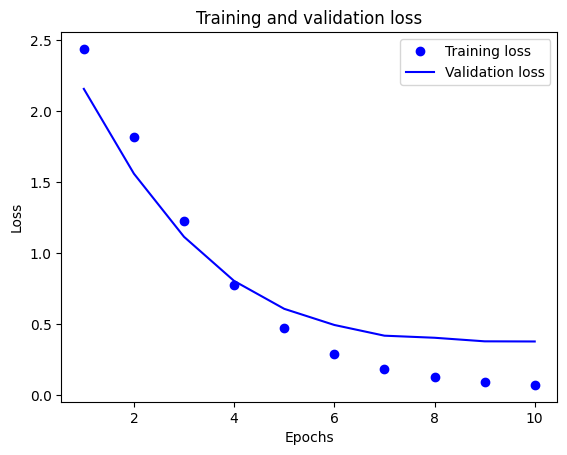

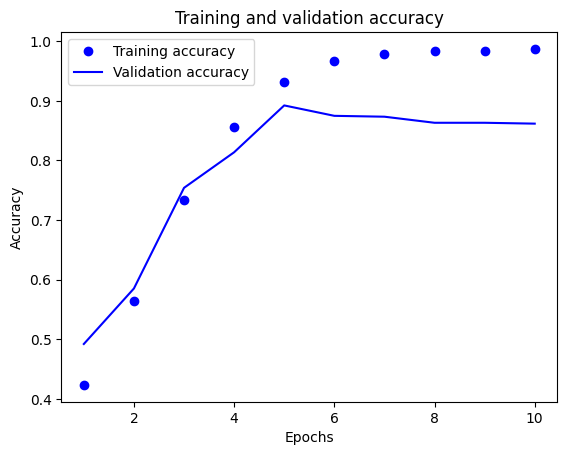

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8534 - loss: 0.4246
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
mortgage payment main |PRED| Internet, phone and streaming services |TRUE| Rent/Mortgage
monthly payment apartment willow dr |PRED| Internet, phone and streaming services |TRUE| Rent/Mortgage
housing expense maple |PRED| Public Transport |TRUE| Rent/Mortgage
Mistakes 3


In [89]:
# How to transform the textual input into vector representation
text_vectorization = TextVectorization(
    output_mode="multi_hot",
    max_tokens=25000,
    ngrams=2,
    #output_mode ='tf_idf',
    #standardize=custom_standardization_fn,
    #split=custom_split_fn,
)

train_texts = dataset_train['human_strings'].to_list()
text_vectorization.adapt(train_texts)

vocabulary = text_vectorization.get_vocabulary()
inverse_vocab = dict(enumerate(vocabulary))

print(text_vectorization.vocabulary_size())

batch_size = 128

val_texts = dataset_val['human_strings'].to_list()
#val_texts = text_vectorization(val_texts) # Encoded validation dataset

test_texts = dataset_test['human_strings'].to_list()
#test_texts = text_vectorization(test_texts)

train_ds = tf.data.Dataset.from_tensor_slices((train_texts, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((val_texts, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((test_texts, y_test))

train_ds = train_ds.shuffle(4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[4])
    print("targets[0]:", targets[4])
    break

model = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    #layers.Dense(32, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint("bigrams_expenses_model.keras",
                                    save_best_only=True)
]

history = model.fit(binary_1gram_train_ds,
                    epochs=10,
                    #batch_size=512,
                    validation_data=binary_1gram_val_ds,
                    callbacks=callbacks
                   )

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

results = model.evaluate(binary_1gram_test_ds)

strategies.append({'experiment': 'Bigrams - Multi-hot-encoded- Pure sequential dense model',
                   'loss': results[0],
                   'test_accuracy': results[1]})

predictions = model.predict(binary_1gram_test_ds)

mistakes = 0
for i, pred in enumerate(predictions[0:5]):
    text = test_texts[i]
    label = y_test_labels[i]
    predicted_label = inverse_label_dict[np.argmax(pred)]
    if predicted_label != label:
        mistakes += 1
        print(text, '|PRED|', predicted_label, '|TRUE|', label)
print('Mistakes', mistakes)

raw_text_data = tf.convert_to_tensor(test_texts)

trained_model = keras.models.load_model("bigrams_expenses_model.keras")
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = trained_model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

inference_model.save('bigram_expenses_inference_model.keras')

#### Model 3 - Sequential Dense models - IDF-TF - Unigrams

{'name': 'text_vectorization_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'max_tokens': 25000, 'standardize': 'lower_and_strip_punctuation', 'split': 'whitespace', 'ngrams': 1, 'output_mode': 'tf_idf', 'output_sequence_length': None, 'pad_to_max_tokens': False, 'sparse': False, 'ragged': False, 'vocabulary': None, 'idf_weights': None, 'encoding': 'utf-8', 'vocabulary_size': 981}
981
inputs.shape: (32, 981)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32, 14)
targets.dtype: <dtype: 'float64'>
inputs[0]: tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        3.7299726 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.


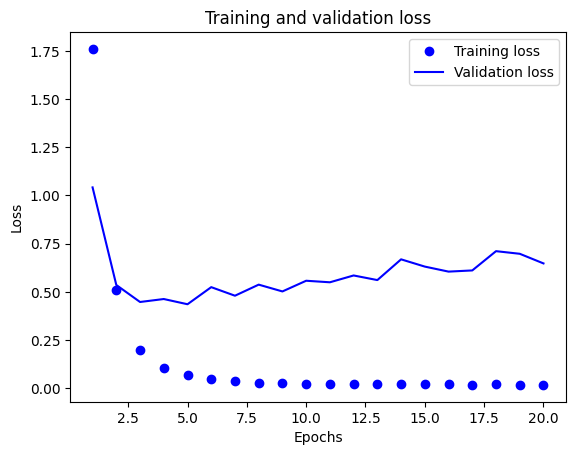

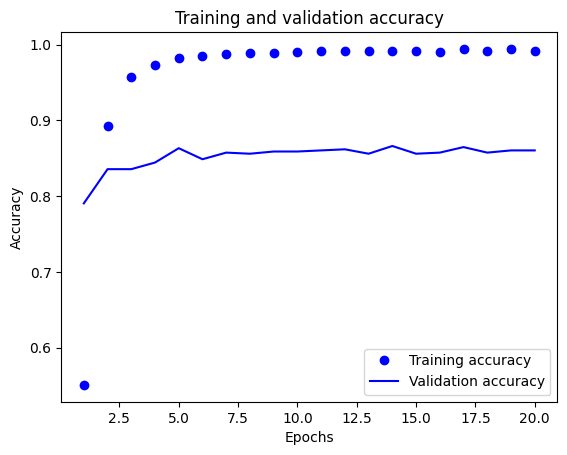

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8654 - loss: 0.6391 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
mortgage payment main |PRED| Internet, phone and streaming services |TRUE| Rent/Mortgage
monthly payment apartment willow dr |PRED| Internet, phone and streaming services |TRUE| Rent/Mortgage
housing expense maple |PRED| Fuel/Gasoline |TRUE| Rent/Mortgage
mortgage |PRED| Internet, phone and streaming services |TRUE| Rent/Mortgage
mortgage |PRED| Internet, phone and streaming services |TRUE| Rent/Mortgage
mortgage check |PRED| Vehicle Maintenance & Repairs |TRUE| Rent/Mortgage
check mortgage |PRED| Vehicle Maintenance & Repairs |TRUE| Rent/Mortgage
replaced broken door handle |PRED| Vehicle Maintenance & Repairs |TRUE| Home Maintenance & Repairs
fixed clogged bathroom vent |PRED| Vehicle Maintenance & Repairs |TRUE| Home Maintenance & Repairs
carpentry shelf |PRED| Internet, phone and streaming services |TRUE| Home Maintenance & Repairs
stand mixer |PRED| Internet, phone and

In [90]:
# How to transform the textual input into vector representation
text_vectorization = TextVectorization(
    #output_mode="multi_hot",
    max_tokens=25000,
    ngrams=1,
    output_mode ='tf-idf',
    #standardize=custom_standardization_fn,
    #split=custom_split_fn,
)

train_texts = dataset_train['human_strings'].to_list()
text_vectorization.adapt(train_texts)
#text_vectorization.set_vocabulary(train_texts)

print(text_vectorization.get_config())

vocabulary = text_vectorization.get_vocabulary()
inverse_vocab = dict(enumerate(vocabulary))

print(text_vectorization.vocabulary_size())

batch_size = 32

val_texts = dataset_val['human_strings'].to_list()

test_texts = dataset_test['human_strings'].to_list()

train_ds = tf.data.Dataset.from_tensor_slices((train_texts, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((val_texts, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((test_texts, y_test))

train_ds = train_ds.shuffle(4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

#text_vectorization.adapt(train_ds..batch(1024))

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[4])
    print("targets[0]:", targets[4])
    break

model = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    #layers.Dense(32, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint("idf_tf_expenses_model.keras",
                                    save_best_only=True)
]

history = model.fit(binary_1gram_train_ds,
                    epochs=20,
                    #batch_size=512,
                    validation_data=binary_1gram_val_ds,
                   callbacks=callbacks
                   )

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

results = model.evaluate(binary_1gram_test_ds)

strategies.append({'experiment': 'Unigrams - TDF-IF- Pure sequential dense model',
                   'loss': results[0],
                   'test_accuracy': results[1]})

predictions = model.predict(binary_1gram_test_ds)

mistakes = 0
for i, pred in enumerate(predictions):
    text = test_texts[i]
    label = y_test_labels[i]
    predicted_label = inverse_label_dict[np.argmax(pred)]
    if predicted_label != label:
        mistakes += 1
        print(text, '|PRED|', predicted_label, '|TRUE|', label)
print('Mistakes', mistakes)

trained_model = keras.models.load_model("idf_tf_expenses_model.keras")
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = trained_model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

inference_model.save('tf_idf_expenses_unigram_inference_model.keras')

### Model 4 - Models with embedding layer

982
Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1162 - loss: 2.5894 - val_accuracy: 0.1456 - val_loss: 2.5389
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1541 - loss: 2.5266 - val_accuracy: 0.1426 - val_loss: 2.5375
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1385 - loss: 2.5451 - val_accuracy: 0.1426 - val_loss: 2.5388
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1426 - loss: 2.5478 - val_accuracy: 0.1456 - val_loss: 2.5387
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1443 - loss: 2.5436 - val_accuracy: 0.1456 - val_loss: 2.5386
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1438 - loss: 2.5422 - val_accuracy: 0.1630 - val_loss: 2.5338
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1581 - loss: 2.5333 - val_accuracy: 0.1456 - val_loss: 2.5341
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1480 - loss: 2.5289 - val_accuracy: 0.1456

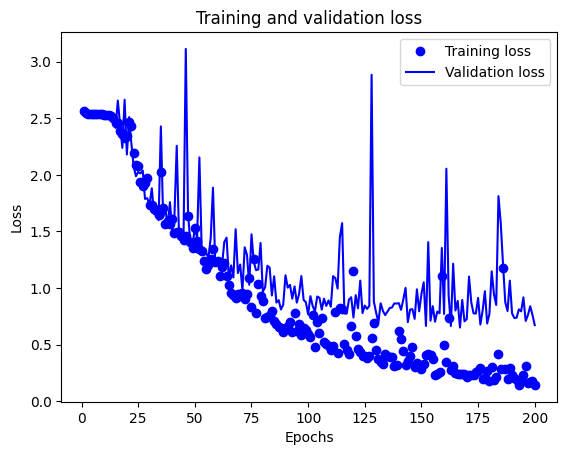

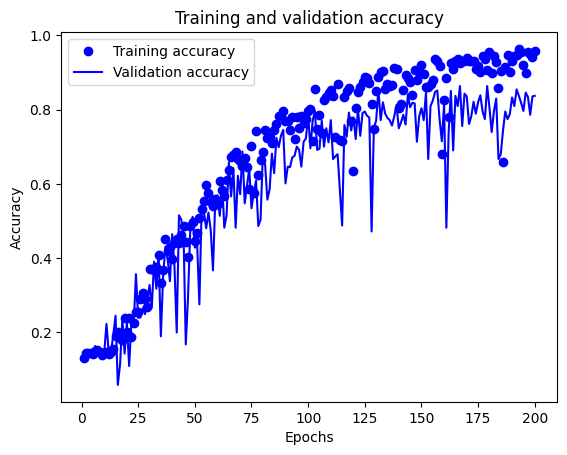

In [92]:
max_features = 20000
sequence_length = 250
embedding_dim = 100

text_vectorization = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

train_texts = dataset_train['human_strings'].to_list()
text_vectorization.adapt(train_texts)

vocabulary = text_vectorization.get_vocabulary()
inverse_vocab = dict(enumerate(vocabulary))

print(text_vectorization.vocabulary_size())

batch_size = 64

val_texts = dataset_val['human_strings'].to_list()
#val_texts = text_vectorization(val_texts) # Encoded validation dataset

test_texts = dataset_test['human_strings'].to_list()
#test_texts = text_vectorization(test_texts)

train_ds = tf.data.Dataset.from_tensor_slices((train_texts, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((val_texts, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((test_texts, y_test))

train_ds = train_ds.shuffle(4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)


model = keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    #layers.Dropout(0.2),
    #layers.GlobalMaxPool1D(),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    #layers.Dense(32, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])
model.compile(optimizer="adam",
              #optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint("expenses_embedding_model.keras",
                                    save_best_only=True)
]

history = model.fit(int_train_ds,
                    epochs=200,
                    #batch_size=512,
                    callbacks=callbacks,
                    validation_data=int_val_ds)

results = model.evaluate(int_test_ds)

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

strategies.append({'experiment': 'Embedding layer (100 dims) - trainable - Pure dense model',
                   'loss': results[0],
                   'test_accuracy': results[1]})


### Results

In [93]:
pd.DataFrame(data=strategies).sort_values(by='test_accuracy', ascending=False)

,experiment,loss,test_accuracy
1,Unigrams - Pure sequential dense model,0.414911,0.855908
3,Unigrams - TDF-IF- Pure sequential dense model,0.637050,0.853026
0,Unigrams - Pure sequential dense model,0.439524,0.850144
2,Bigrams - Multi-hot-encoded- Pure sequential d...,0.400441,0.841499
5,Embedding layer (100 dims) - trainable - Pure ...,0.619104,0.841499
4,Embedding layer (100 dims) - trainable - Pure ...,1.748121,0.576369


References:

https://www.tensorflow.org/tutorials/keras/text_classification<br/>
https://realpython.com/python-keras-text-classification/